In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score, recall_score, balanced_accuracy_score, roc_curve
from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE

# Reading, Preprocessing and EDA

In [3]:
Train_path = "../datasets/ApsFailure/aps_failure_training_set_processed_8bit.csv"
Test_path = "../datasets/ApsFailure/aps_failure_test_set_processed_8bit.csv"
train_df = pd.read_csv(Train_path)
test_df = pd.read_csv(Test_path)

In [4]:
print(train_df.isnull().sum().sum(), train_df.isna().sum().sum())

0 0


In [5]:
list_dtype = [train_df[i].dtype for i in train_df.columns]
dict((i, list_dtype.count(i)) for i in list_dtype)

{dtype('float64'): 171}

In [6]:
label_encoder = LabelEncoder()
train_df['class'] = label_encoder.fit_transform(train_df['class'])
test_df['class'] = label_encoder.transform(test_df['class'])

In [7]:
from sklearn.preprocessing import StandardScaler
scl = StandardScaler()
scl.fit(train_df)
scl.transform(train_df)
y_train = train_df['class']
y_test = test_df['class']
X_train = train_df.drop(['class'], axis = 1)
X_test = test_df.drop(['class'], axis = 1)

In [8]:
class CentroidSMOTE():
    def __init__(self, sampling_strategy='auto', random_state=42, k_neighbors=5, m_vertices=3):
        self.sampling_strategy = sampling_strategy
        self.random_state = random_state
        self.k_neighbors = k_neighbors
        self.m_vertices = m_vertices
    
    @staticmethod
    def nearest_neighbor(X, k):
        from sklearn.neighbors import NearestNeighbors
        nbs=NearestNeighbors(n_neighbors=k+1,metric='euclidean',algorithm='kd_tree').fit(X)
        euclidean,indices= nbs.kneighbors(X)
        return indices[:, 1:]
    
    def fit_resample(self, X, y):
        
        (unique, freq) = np.unique(y, return_counts=True)
        frequency = dict(zip(unique, freq))
        max_frequency = max(frequency.values())
        
        if self.sampling_strategy == 'auto':
            sampling_strategy = {}
            for (key, value) in frequency.items():
                sampling_strategy[key] = max_frequency - value
            self.sampling_strategy = sampling_strategy
            
        data = {}
        for (key, value) in self.sampling_strategy.items():
            if value == 0:
                continue
            X_small = X[y == key]
            indices = self.nearest_neighbor(X_small, self.k_neighbors)
            new_data = []
            for idx in np.random.choice(np.arange(len(X_small)), size=value):
                p = X_small[idx]
                nnarray = indices[idx]
                q = X_small[np.random.choice(nnarray, size=self.m_vertices-1, replace=False)]
                new_data.append(np.sum(np.vstack([p, q]), axis=0)/self.m_vertices)
            X_new = np.vstack(new_data)
            data[key] = X_new
        
        for (key, value) in data.items():
            X = np.vstack([X, value])
            y = np.concatenate([y, np.ones(len(value))*key])
        
        X, y = shuffle(X, y, random_state=self.random_state)
        
        return X, y        

In [9]:
def score(X_test, y_test, model):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    print(f"Accuracy: {acc:.6f}")
    print(f"Error Rate: {1-acc}")
    Recall = recall_score(y_test, y_pred, average='macro')      
    print(f"Mean Recall: {Recall}")
    print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_test, y_pred)}")
    Array_prec_recall_f = precision_recall_fscore_support(y_test, y_pred, average='macro')
#                                                                         average = 'micro', 'macro', 'weighted'
    print(f"Precision: {Array_prec_recall_f[0]}")
    print(f"F-Score: {Array_prec_recall_f[2]}")
          
    
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    print(len(y_pred), len(y_test))
    for i in range(len(y_pred)): 
        if y_test[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_test[i]!=y_pred[i]:
           FP += 1
        if y_test[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_test[i]!=y_pred[i]:
           FN += 1
    if TN + FP == 0: 
      Selectivity = 0
    else:
      Selectivity = TN/(TN + FP)
    G_mean = np.sqrt(Selectivity*Recall) 
    print(f"Selectivity: {Selectivity}") 
    print(f"G_mean: {G_mean}")   
    
    
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display.plot()
    plt.show()
    
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
   
        

In [10]:
pipeline = Pipeline([
    ('classifier', KNeighborsClassifier())
])

parameters = {
    'classifier__n_neighbors' : [3, 5, 7, 9, 11],
}

In [11]:
y_test = y_test.to_numpy()
y_train = y_train.to_numpy()
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.986375
Error Rate: 0.013624999999999998
Mean Recall: 0.7262506666666666
Balanced Accuracy Score: 0.7262506666666666
Precision: 0.958000505093952
F-Score: 0.8011927976163198
16000 16000
Selectivity: 0.999168
G_mean: 0.8518488282036901


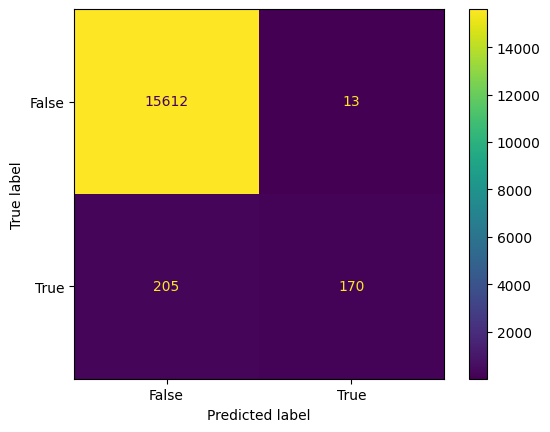

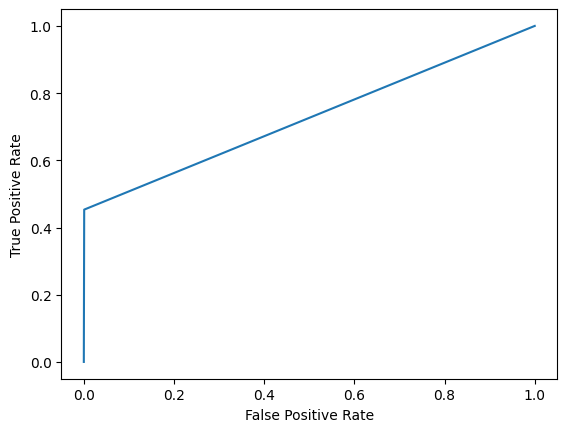

In [12]:
clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
best_clf = clf.fit(X_train, y_train)
score(X_test, y_test, best_clf)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.975750
Error Rate: 0.024249999999999994
Mean Recall: 0.9082026666666667
Balanced Accuracy Score: 0.9082026666666667
Precision: 0.7429439908242856
F-Score: 0.8027938219573831
16000 16000
Selectivity: 0.979072
G_mean: 0.9429717923981962


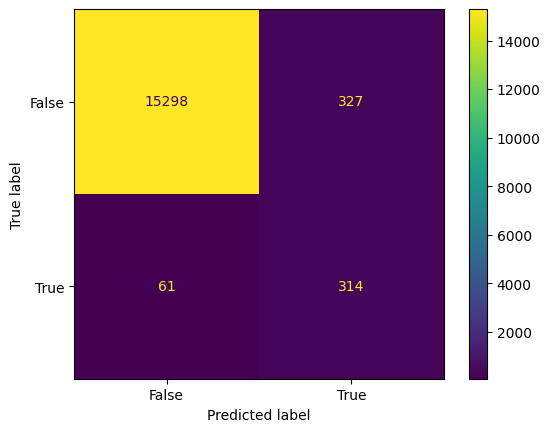

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.972688
Error Rate: 0.027312499999999962
Mean Recall: 0.9144426666666667
Balanced Accuracy Score: 0.9144426666666667
Precision: 0.7261226073162275
F-Score: 0.7900556961940177
16000 16000
Selectivity: 0.975552
G_mean: 0.9445032410489654


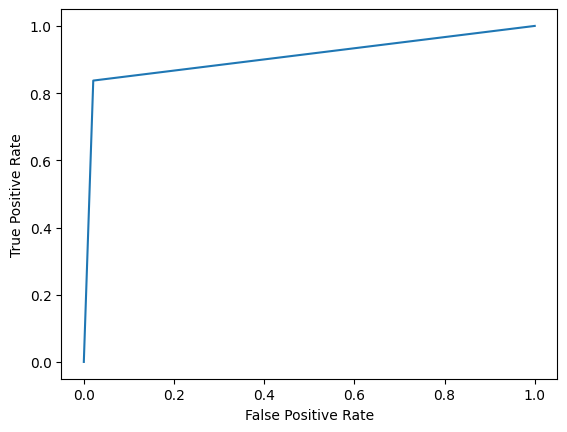

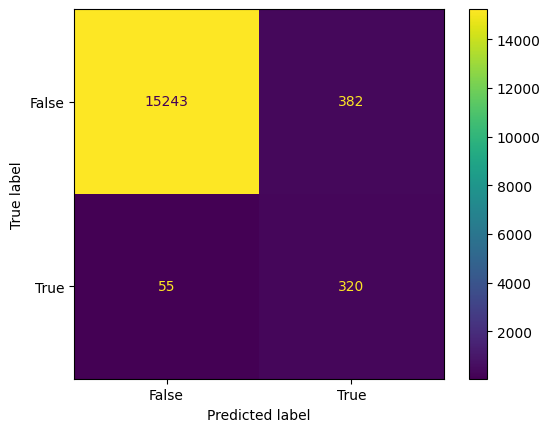

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.970688
Error Rate: 0.029312499999999964
Mean Recall: 0.9108160000000001
Balanced Accuracy Score: 0.9108160000000001
Precision: 0.7159418144629545
F-Score: 0.7801925804743698
16000 16000
Selectivity: 0.973632
G_mean: 0.9417003789486336


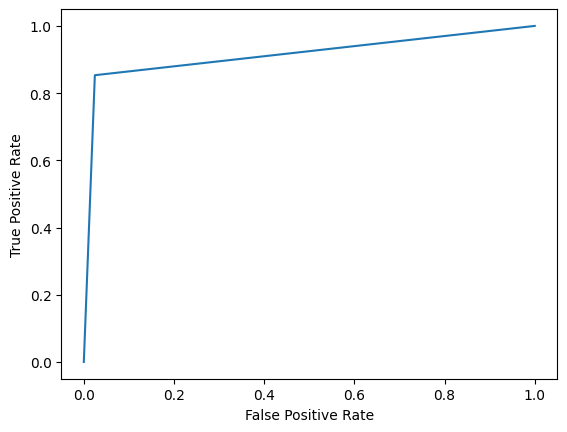

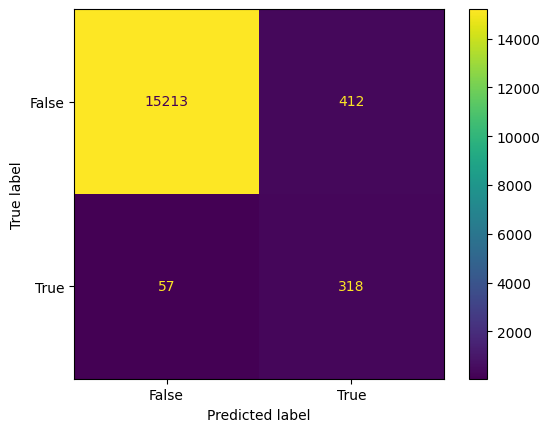

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.970562
Error Rate: 0.029437500000000005
Mean Recall: 0.9198613333333334
Balanced Accuracy Score: 0.9198613333333334
Precision: 0.7161895038474504
F-Score: 0.7822931722302808
16000 16000
Selectivity: 0.973056
G_mean: 0.946084874399755


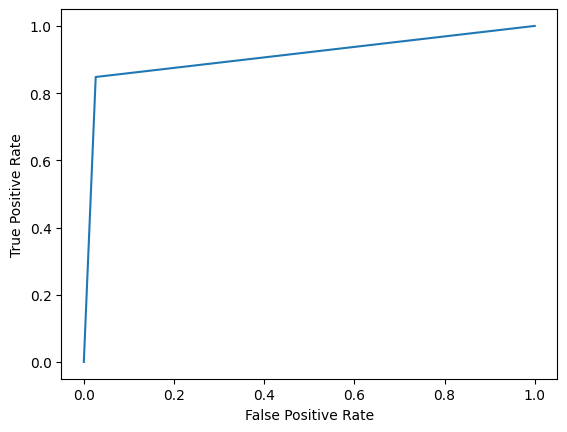

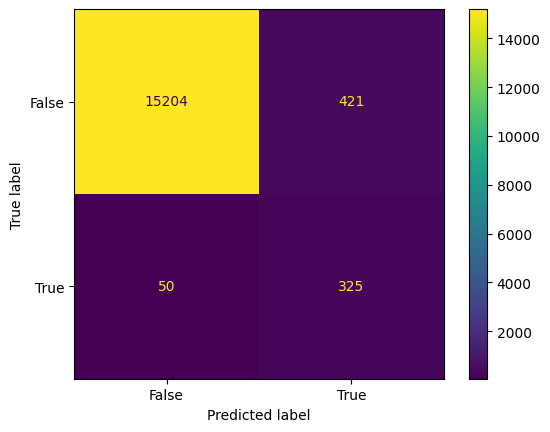

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.969625
Error Rate: 0.03037500000000004
Mean Recall: 0.9245866666666667
Balanced Accuracy Score: 0.9245866666666667
Precision: 0.7124040961221464
F-Score: 0.7797121209099431
16000 16000
Selectivity: 0.97184
G_mean: 0.9479189343679835


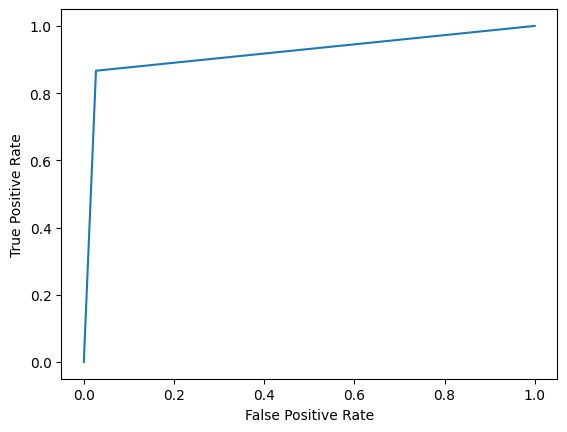

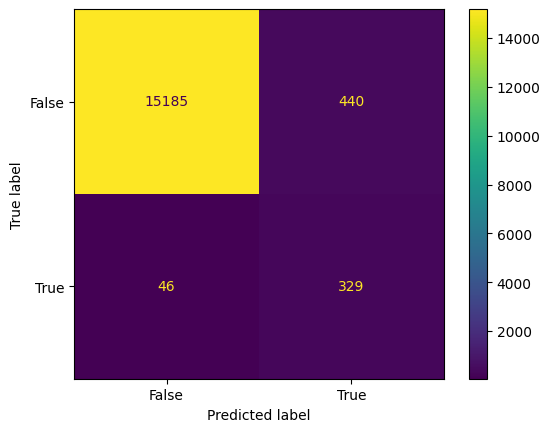

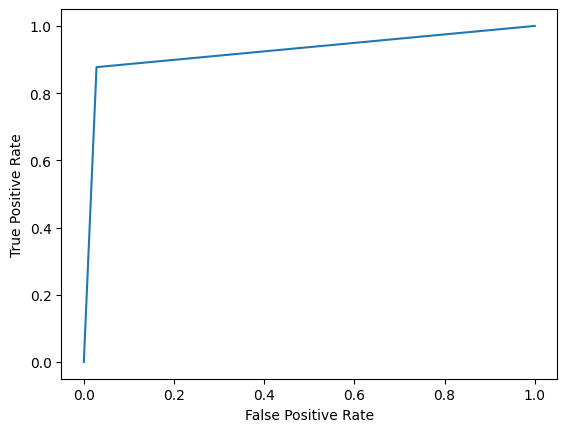

In [13]:
sm_list = []
for i in [3, 5, 7, 9, 11]:
    sm_list.append(SMOTE(random_state=42, k_neighbors=i))
    
for sm in sm_list:
    X_new, y_new = sm.fit_resample(X_train, y_train)
    pipeline = Pipeline([
        ('classifier', KNeighborsClassifier())
    ])

    parameters = {
        'classifier__n_neighbors' : [3, 5, 7, 9, 11],
    }

    clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
    best_clf = clf.fit(X_new, y_new)
    score(X_test, y_test, best_clf)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.969500
Error Rate: 0.03049999999999997
Mean Recall: 0.9271253333333334
Balanced Accuracy Score: 0.9271253333333334
Precision: 0.7121033953069549
F-Score: 0.779916848706927
16000 16000
Selectivity: 0.971584
G_mean: 0.9490943787955618


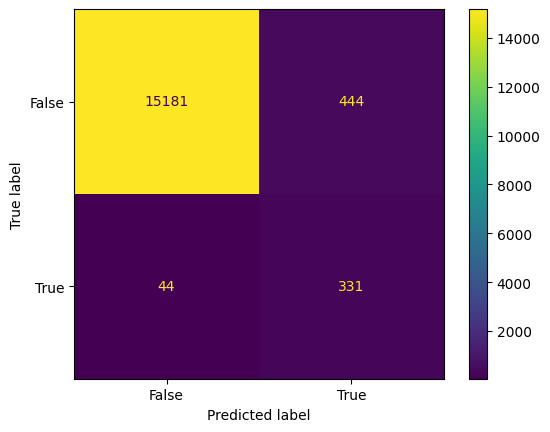

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.965125
Error Rate: 0.03487499999999999
Mean Recall: 0.9339946666666666
Balanced Accuracy Score: 0.9339946666666666
Precision: 0.6955185478465944
F-Score: 0.7648375445710291
16000 16000
Selectivity: 0.966656
G_mean: 0.9501850075123967


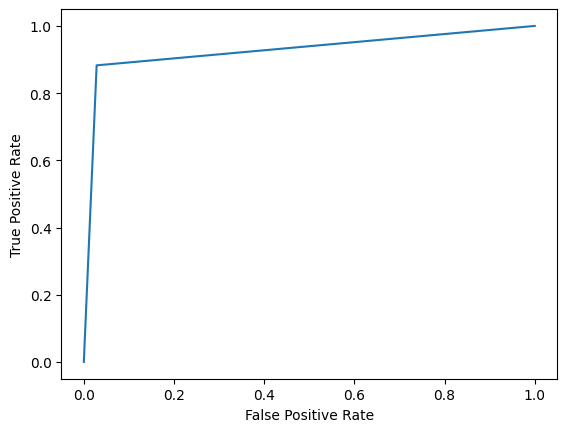

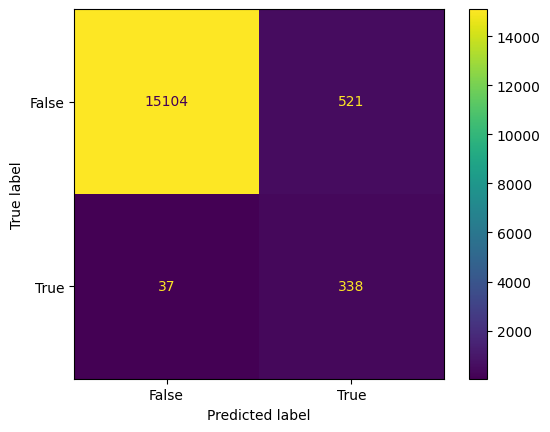

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.962938
Error Rate: 0.0370625
Mean Recall: 0.9328746666666667
Balanced Accuracy Score: 0.9328746666666667
Precision: 0.6878133523843882
F-Score: 0.7567032199051845
16000 16000
Selectivity: 0.964416
G_mean: 0.9485142352795767


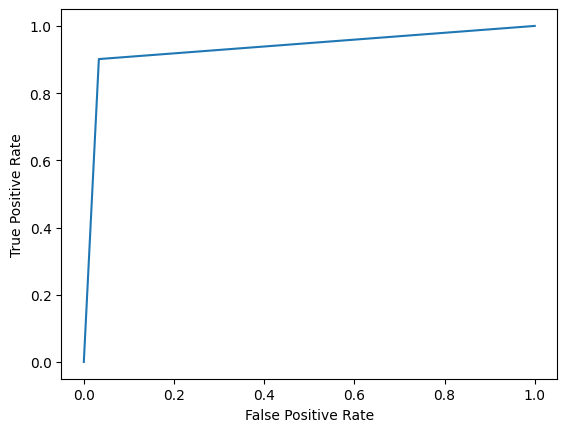

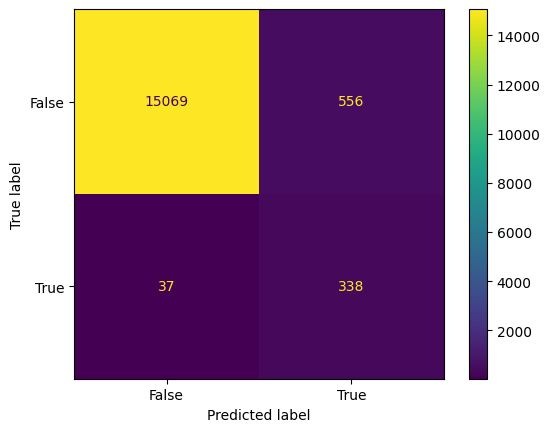

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.965812
Error Rate: 0.03418750000000004
Mean Recall: 0.9369493333333333
Balanced Accuracy Score: 0.9369493333333333
Precision: 0.6983752484097437
F-Score: 0.768210953245432
16000 16000
Selectivity: 0.967232
G_mean: 0.9519702608688291


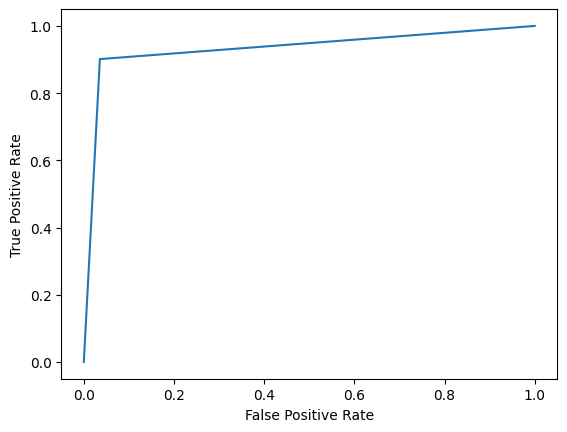

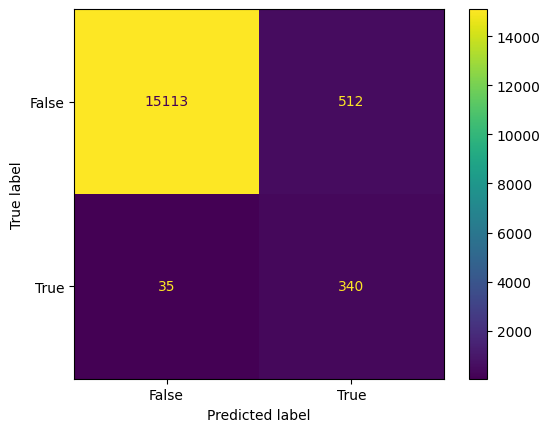

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.969125
Error Rate: 0.030874999999999986
Mean Recall: 0.9347413333333333
Balanced Accuracy Score: 0.9347413333333333
Precision: 0.7112348124673122
F-Score: 0.780516240021042
16000 16000
Selectivity: 0.970816
G_mean: 0.9526079163335424


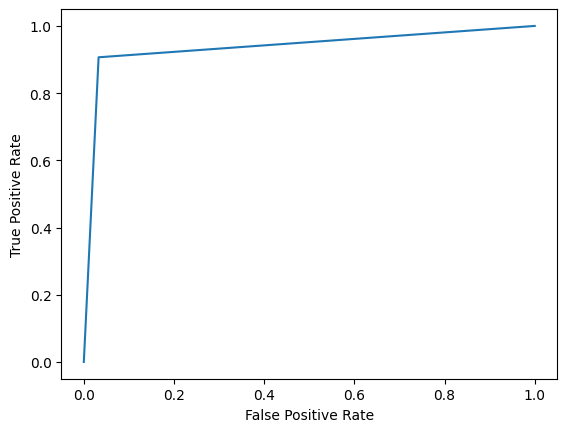

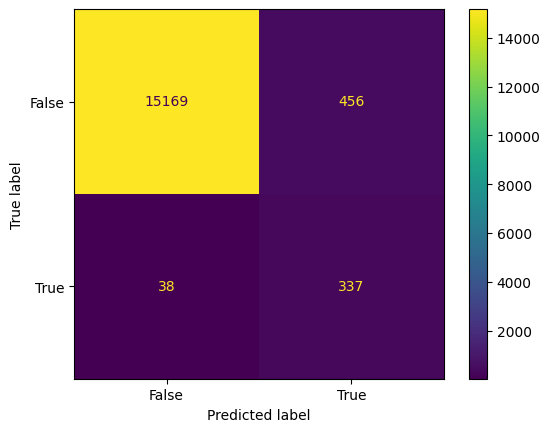

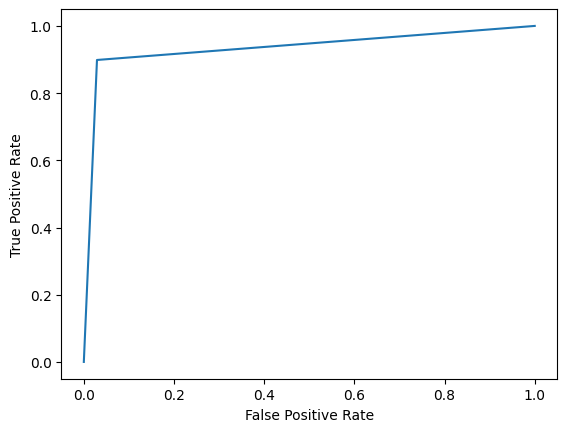

In [14]:
csm_list = []
for (i,j) in [(5,3), (7,3), (9,3), (7,5), (9,7)]:
    csm_list.append(CentroidSMOTE(k_neighbors=i, m_vertices=j))
    
for csm in csm_list:
    X_new, y_new = csm.fit_resample(X_train, y_train)
    pipeline = Pipeline([
        ('classifier', KNeighborsClassifier())
    ])

    parameters = {
        'classifier__n_neighbors' : [3, 5, 7, 9, 11],
    }

    clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
    best_clf = clf.fit(X_new, y_new)
    score(X_test, y_test, best_clf)